[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/movielens_skorch.ipynb)

In [ ]:
# !pip install tensorflow-gpu==2.0.0-beta1

In [1]:
%load_ext tensorboard

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, datetime
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
# path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/goodbooks-10k/'  # access from anywhere
path = 'data/goodbooks-10k/'  # if the files are local
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
df = pd.concat((train, test), ignore_index=True)

In [4]:
df.head()

,user_id,book_id,rating
0,26985,1,5
1,32332,1899,5
2,50054,3114,4
3,33313,2800,4
4,12666,1479,5


In [5]:
df.shape

(5976479, 3)

In [6]:
n_users = df.user_id.nunique()
n_items = df.book_id.nunique()
print('Number of users:', n_users)
print('Number of items:', n_items)

Number of users: 53424
Number of items: 10000


In [7]:
max_users = df.user_id.max()
max_items = df.book_id.max()
print("Max user ID:", max_users)
print("Max movie ID:", max_items)

Max user ID: 53423
Max movie ID: 9999


## Predict ratings

### Trunk of model
We will re-use the item embedding layer later on

In [10]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1, embeddings_freq=1)
os.makedirs(logdir, exist_ok=True)

Reusing TensorBoard on port 6006 (pid 14720), started 0:15:18 ago. (Use '!kill 14720' to kill it.)

In [12]:
# item embedding path
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(n_items, 25, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

# user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users, 25, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

### Head of model 
#### Option 1: dot product

In [12]:
# # dot product user and item vectors
# prod = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])

# # create model and compile it
# model = Model([user_input, item_input], prod)
# model.compile('adam', 'mean_squared_error')
# model.summary()

#### Option 2: neural network

In [13]:
from tensorflow.keras import backend as K

def stretch(x):
    return K.sigmoid(x) * (5 - 1) + 1

In [14]:
# concatenate features
conc = Concatenate()([item_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(64, activation='relu')(conc)
d1 = Dropout(.5)(fc1)
fc2 = Dense(32, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
out = Dense(1, activation=stretch)(d2)

# create model and compile it
model = Model([user_input, item_input], out)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 25)        250000      Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 25)        1335600     User-Input[0][0]                 
______________________________________________________________________________________________

### (Optional) load weights from checkpoint

In [8]:
# ignore this if running in colaboratory
checkpoint_path = "models/goodbooks.ckpt"

# Create checkpoint callback
cp_callback = ModelCheckpoint(checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

In [15]:
model.load_weights(checkpoint_path)

Train on 4781183 samples, validate on 1195296 samples
4780544/4781183 [============================>.] - ETA: 0s - loss: 0.6668
Epoch 00001: saving model to models/goodbooks.ckpt
4781183/4781183 [==============================] - 427s 89us/sample - loss: 0.6668 - val_loss: 0.6909


Text(0, 0.5, 'Training Error')

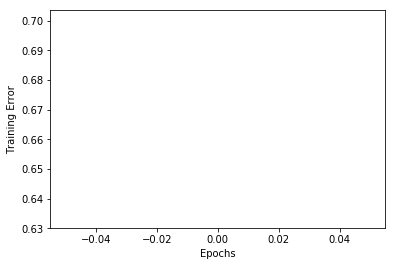

In [20]:
history = model.fit([df.user_id, df.book_id], df.rating, 
                    batch_size=256,
                    epochs=1,
                    verbose=1,
                    validation_split=.2,
                    callbacks=[cp_callback, tensorboard_callback])

In [ ]:
%tensorboard --logdir logs

In [16]:
model.evaluate([df.user_id, df.book_id], df.rating, batch_size=1024)

5976479/5976479 [==============================] - 29s 5us/sample - loss: 0.6437


0.6436596912644581

In [17]:
np.sqrt(0.6437)

0.8023091673413685

In [18]:
predictions = model.predict([df.user_id.head(10), df.book_id.head(10)])

[print(predictions[i], df.rating.iloc[i]) for i in range(0,10)]

[4.7471237] 5
[4.148156] 5
[3.863347] 4
[3.5951762] 4
[4.452484] 5
[3.645379] 3
[4.365432] 5
[3.7191439] 5
[4.4383307] 5
[4.740861] 4


[None, None, None, None, None, None, None, None, None, None]

## Making recommendations

In [21]:
# Creating dataset for making recommendations for the first user
item_data = np.array(list(set(train.book_id)))
item_data[:5]

array([0, 1, 2, 3, 4])

In [22]:
user = np.array([1 for i in range(len(item_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [23]:
predictions = model.predict([user, item_data])

predictions = np.array([a[0] for a in predictions])

# get top 5 predictions
recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

array([3627, 7946, 9565, 1787, 5579], dtype=int64)

In [24]:
# print predicted scores
predictions[recommended_book_ids]

array([4.991747 , 4.9906664, 4.990132 , 4.986417 , 4.9862175],
      dtype=float32)

In [25]:
books[books['book_id'].isin(recommended_book_ids)]

,book_id,original_title,language_code,adult,adult-fiction,adventure,book-club,contemporary,fantasy,fiction,mystery,romance,young-adult
1771,1787,The Calvin and Hobbes Tenth Anniversary Book,eng,0,0,1,0,0,1,1,0,0,1
3567,3627,The Complete Calvin and Hobbes,eng,0,0,0,0,0,1,1,0,0,1
5448,5579,The Calvin and Hobbes Lazy Sunday Book,eng,0,0,1,0,0,1,1,0,0,1
7721,7946,NaN,eng,1,0,0,0,0,0,0,0,0,0
9277,9565,Attack of the Deranged Mutant Killer Monster S...,eng,0,0,1,0,0,1,1,0,0,1
